# Evaluation Metrics + Manipulating Attention Heads in Transformers

The goal is to show how different attention heads have varying significance for transformers trained on multiple tasks by computing gradient-based importance scores, selectively pruning less critical heads, and evaluating the impact on performance.


Tasks
- Evaluation Metrics
- Head Importance Analysis
- Pruning

# Imports

In [ ]:
!pip install datasets

In [ ]:
import math
from typing import List
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
import IPython.display as display

## Evaluation Metrics

### ROUGE-L

The ROUGE-L metric evaluates text summarization quality by measuring the Longest Common Subsequence (LCS) between a machine-generated summary and a reference summary.

ROUGE-L is particularly useful for assessing how well a summary captures the main ideas while maintaining sentence-level structure similarity. It doesn't require consecutive matches, making it more flexible than strict n-gram methods.

You may look at section 3.1 of the [original ROUGE paper by Lin (2004)](https://aclanthology.org/W04-1013/) and implement sentence-level LCS.

In [ ]:
def rouge_l(prediction: str, reference: str, beta=1) -> float:
    """
    Computes the ROUGE-L F measure based on the Longest Common Subsequence (LCS).
    """

    # BEGIN CODE : eval1.rouge_l

    # convert input strings to lowercase and split into words
    p = prediction.lower().split()
    r = reference.lower().split()

    # check if either input is empty
    if not p or not r:
        return 0.0

    # assign lengths according to paper notation
    m = len(r)  # reference length
    n = len(p)  # prediction length

    # initialize dp table for lcs calculation
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # fill dp table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if r[i - 1] == p[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    # get lcs length
    lcs = dp[m][n]

    # calculate precision and recall
    prec = lcs / n
    rec = lcs / m

    # check if precision or recall is zero
    if prec == 0 or rec == 0:
        return 0.0

    # compute f score
    return ((1 + beta**2) * prec * rec) / ((beta**2 * prec) + rec)

    # END CODE


### BLEU

BLEU (Bilingual Evaluation Understudy) is a standard metric for evaluating machine translation quality by comparing the similarity between machine-generated translations and reference translations using n-gram precision.

It was developed at IBM in 2001 and remains one of the most popular automated metrics for translation evaluation due to its correlation with human judgments.

Your implementation should follow the original BLEU formulation as described by [Papineni et al. (2002)](https://aclanthology.org/P02-1040/) and summarized on [Wikipedia](https://en.wikipedia.org/wiki/BLEU), with the addition of a smoothing component (as described below).

In [ ]:
def bleu_score(candidate: str, reference: str) -> float:
    """
    Computes the BLEU score for a candidate translation given a reference translation
    using modified n-gram precision up to 4-grams.
    """
    # BEGIN CODE : eval1.bleu_score
    # tokenize candidate and reference
    c = candidate.lower().split()
    r = reference.lower().split()

    # check if candidate is empty
    if len(c) == 0:
        return 0.0

    # get max n gram order based on candidate and reference length
    max_n = min(4, len(c), len(r))

    # store precision values
    precs = []

    for n in range(1, max_n + 1):
        # count candidate n grams
        c_ng = {}
        for i in range(len(c) - n + 1):
            ng = tuple(c[i:i + n])
            c_ng[ng] = c_ng.get(ng, 0) + 1
        tot_c_ng = sum(c_ng.values())

        # count reference n grams
        r_ng = {}
        for i in range(len(r) - n + 1):
            ng = tuple(r[i:i + n])
            r_ng[ng] = r_ng.get(ng, 0) + 1

        # count matching n grams
        match = 0
        for ng, cnt in c_ng.items():
            max_r_cnt = r_ng.get(ng, 0)
            match += min(cnt, max_r_cnt)

        # compute precision with smoothing
        if tot_c_ng == 0:
            prec_n = 0.0
        else:
            if match == 0 and len(c) > 3:     #when len is suitable for 4-gram
                prec_n = (match + 1) / (tot_c_ng + 1)
            elif match == 0 and len(c) < 4:      #when len is less for 4-gram
                add_zero = 1                      #add 0 precision  only if no other word matches otherwise score will be 1 as exponent of 0 is 1
                for p in precs:                   #and we are not using smoothing for this case if we use it, then for string with 0 matches also value doesnot come to be 0
                    if p != 0:
                        add_zero = 0
                        break
                if add_zero:
                    prec_n = match / tot_c_ng
                    precs.append(prec_n)
                continue
            else:
                prec_n = match / tot_c_ng
        precs.append(prec_n)

    # add precision of 1.0 for higher order n grams
    for _ in range(max_n + 1, 5):
        precs.append(1.0)

    # compute geometric mean of precisions
    sum_logs = 0.0
    for p in precs:
        if p == 0:
            return 0.0
        sum_logs += math.log(p)
    geo_mean = math.exp(sum_logs / max_n)

    # compute brevity penalty
    c_len = len(c)
    r_len = len(r)
    bp = 1.0 if c_len >= r_len else math.exp(1 - (r_len / c_len))

    return bp * geo_mean

    # END CODE


## Attention Head Importance Analysis

In this section, you'll analyze the importance of attention heads in T5 transformer models across different NLP tasks. The AttentionHeadImportance class provides tools to:
- Load and preprocess datasets for various NLP tasks (summarization with CNN/DailyMail and translation with WMT16)
- Compute the importance of attention heads in the T5 model
- Visualize the importance scores as heatmaps

The core of this section is implementing the compute_head_importance method, which measures how much each attention head contributes to the model's performance. This method:
- Takes a dataloader and optional head masks as input
- Returns importance scores for encoder, decoder, and cross-attention heads

Your implementation should be flexible enough to work with different T5 variants (t5-small, t5-base, t5-large, etc.) without hardcoding model-specific parameters.

After computing the head importance scores, you'll visualize them using heatmaps to compare which heads are most critical for different NLP tasks. These insights can be valuable for understanding how transformer models process different types of language tasks, how different attention heads may be important for different tasks and potentially for pruning less important heads to improve efficiency.

The head importance scores you calculate will be useful for the next part of the assignment, where you'll explore head pruning techniques.


You can implement the `compute_head_importance` method using any one of the following approaches—or even propose your own method.

1. **Gradient-based scoring**:  
   Compute the gradients of the loss with respect to the head masks (as in [Michel et al. (2019)](https://arxiv.org/abs/1905.10650)). Larger gradient magnitudes indicate that a head has a larger impact on the loss, and hence is more important.

2. **Simple ablation**:  
   Systematically mask (disable) each attention head one at a time and measure the performance drop (e.g., in terms of loss). Heads whose removal causes larger performance degradation are deemed more important.

3. **Attention weight magnitude**:  
   Average the attention weights for each head across samples and time steps. Heads with higher average attention weights might be considered more influential.

4. **Confidence analysis**:  
   Evaluate the sharpness or concentration of each head's attention distribution. Heads that produce less uniform (more confident) distributions may be more specialized and important.

5. **Layer-wise relevance propagation (LRP)**:  
   Use relevance propagation techniques (as in [Voita et al. (2019)](https://arxiv.org/abs/1905.09418)) to trace how much each head contributes to the final output.


In [ ]:
 ## ==== BEGIN EVALUATION PORTION

class AttentionHeadImportance:
    def __init__(self, model_name="t5-base", device=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if device is None else device
        self.model = T5ForConditionalGeneration.from_pretrained(model_name).to(self.device)
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)

        # BEGIN CODE : ahi.__init__

        # enable attention outputs and return dict
        self.model.config.output_attentions = True
        self.model.config.return_dict = True

        # store model config details
        self.num_encoder_layers = self.model.config.num_layers
        self.num_decoder_layers = self.model.config.num_decoder_layers if hasattr(self.model.config, "num_decoder_layers") else self.model.config.num_layers
        self.num_heads = self.model.config.num_heads

        # END CODE


    def get_dataloader(self, path, name=None, split="validation", batch_size=8, shuffle=False):
        dataset = load_dataset(path, name, split=split)
        dataset = self._preprocess_dataset(path, dataset)
        dataset.set_format(type="torch", columns=["input_ids", "labels"])
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    def _preprocess_dataset(self, path, dataset):
        if path == "glue":
            return self._preprocess_sst2(dataset)
        elif path == "squad":
            return self._preprocess_squad(dataset)
        elif path == "cnn_dailymail":
            return self._preprocess_cnn_dailymail(dataset)
        elif path == "wmt16":
            return self._preprocess_wmt16(dataset)
        else:
            raise ValueError(f"Preprocessing for dataset {path} is not implemented.")

    def _preprocess_sst2(self, dataset):
        def preprocess(batch):
            source_texts = ["sst2 sentence: " + ex for ex in batch["sentence"]]
            target_texts = ["positive" if label == 1 else "negative" for label in batch["label"]]
            inputs = self.tokenizer(source_texts, padding="max_length", truncation=True, max_length=128)
            labels = self.tokenizer(target_texts, padding="max_length", truncation=True, max_length=10)
            return {"input_ids": inputs["input_ids"], "labels": labels["input_ids"]}

        dataset = dataset.map(preprocess, batched=True, remove_columns=["sentence", "label", "idx"])
        return dataset

    def _preprocess_squad(self, dataset):
        def preprocess(batch):
            source_texts = ["question: " + q + " context: " + c for q, c in zip(batch["question"], batch["context"])]
            target_texts = [ans["text"][0] if len(ans["text"]) > 0 else "" for ans in batch["answers"]]
            inputs = self.tokenizer(source_texts, padding="max_length", truncation=True, max_length=128)
            labels = self.tokenizer(target_texts, padding="max_length", truncation=True, max_length=32)
            return {"input_ids": inputs["input_ids"], "labels": labels["input_ids"]}

        dataset = dataset.map(preprocess, batched=True, remove_columns=["id", "title", "context", "question", "answers"])
        return dataset

    def _preprocess_cnn_dailymail(self, dataset):
        def preprocess(batch):
            source_texts = ["summarize: " + text for text in batch["article"]]
            target_texts = batch["highlights"]
            inputs = self.tokenizer(source_texts, padding="max_length", truncation=True, max_length=512)
            labels = self.tokenizer(target_texts, padding="max_length", truncation=True, max_length=128)
            return {"input_ids": inputs["input_ids"], "labels": labels["input_ids"]}

        dataset = dataset.map(preprocess, batched=True, remove_columns=["article", "highlights", "id"])
        return dataset

    def _preprocess_wmt16(self, dataset):
        def preprocess(batch):
            source_texts = ["translate English to German: " + ex["en"] for ex in batch["translation"]]
            target_texts = [ex["de"] for ex in batch["translation"]]
            inputs = self.tokenizer(source_texts, padding="max_length", truncation=True, max_length=128)
            labels = self.tokenizer(target_texts, padding="max_length", truncation=True, max_length=128)
            return {"input_ids": inputs["input_ids"], "labels": labels["input_ids"]}

        dataset = dataset.map(preprocess, batched=True, remove_columns=["translation"])
        return dataset



    def compute_head_importance(self, dataloader, encoder_head_mask=None, decoder_head_mask=None, cross_attn_head_mask=None):
        """
        Computes the importance of attention heads in the T5 model by measuring their influence on model predictions.
        """
        # BEGIN CODE : ahi.compute_head_importance

        # initialize masks if not provided
        if encoder_head_mask is None:
            encoder_head_mask = torch.ones((self.num_encoder_layers, self.num_heads), device=self.device, requires_grad=True)
        if decoder_head_mask is None:
            decoder_head_mask = torch.ones((self.num_decoder_layers, self.num_heads), device=self.device, requires_grad=True)
        if cross_attn_head_mask is None:
            cross_attn_head_mask = torch.ones((self.num_decoder_layers, self.num_heads), device=self.device, requires_grad=True)

        # set model to eval mode
        self.model.eval()

        # initialize accumulators
        enc_imp = torch.zeros((self.num_encoder_layers, self.num_heads), device=self.device)
        dec_imp = torch.zeros((self.num_decoder_layers, self.num_heads), device=self.device)
        cross_imp = torch.zeros((self.num_decoder_layers, self.num_heads), device=self.device)
        total = 0

        # helper hook to accumulate importance
        def get_hook(attn, acc):
            def hook(grad):
                acc.add_((attn * grad).abs().sum(dim=(0, 2, 3)))
                return grad
            return hook

        # iterate over data
        for step, batch in enumerate(dataloader):
            # move batch to device
            ids = batch["input_ids"].to(self.device)
            lbl = batch["labels"].to(self.device)
            bsz = ids.size(0)
            total += bsz

            # clear gradients
            self.model.zero_grad()

            # forward pass
            out = self.model(
                input_ids=ids,
                labels=lbl,
                head_mask=encoder_head_mask,
                decoder_head_mask=decoder_head_mask,
                cross_attn_head_mask=cross_attn_head_mask,
                output_attentions=True,
                return_dict=True
            )
            loss = out.loss

            # get attention tensors
            enc_attn = out.encoder_attentions
            dec_attn = out.decoder_attentions
            cross_attn = out.cross_attentions

            # layerwise accumulators
            enc_acc = [torch.zeros(self.num_heads, device=self.device) for _ in range(len(enc_attn))]
            dec_acc = [torch.zeros(self.num_heads, device=self.device) for _ in range(len(dec_attn))]
            cross_acc = [torch.zeros(self.num_heads, device=self.device) for _ in range(len(cross_attn))]

            # register hooks to capture gradients
            enc_hooks = []
            for i, attn in enumerate(enc_attn):
                hook = attn.register_hook(get_hook(attn, enc_acc[i]))
                enc_hooks.append(hook)

            dec_hooks = []
            for i, attn in enumerate(dec_attn):
                hook = attn.register_hook(get_hook(attn, dec_acc[i]))
                dec_hooks.append(hook)

            cross_hooks = []
            for i, attn in enumerate(cross_attn):
                hook = attn.register_hook(get_hook(attn, cross_acc[i]))
                cross_hooks.append(hook)

            # backward pass
            loss.backward()

            # remove hooks to free memory
            for hook in enc_hooks:
                hook.remove()
            for hook in dec_hooks:
                hook.remove()
            for hook in cross_hooks:
                hook.remove()

            # update accumulators
            for i in range(len(enc_acc)):
                enc_imp[i] += enc_acc[i]
            for i in range(len(dec_acc)):
                dec_imp[i] += dec_acc[i]
            for i in range(len(cross_acc)):
                cross_imp[i] += cross_acc[i]

            # clear gradients for next batch
            self.model.zero_grad()

        # average importance scores
        enc_imp /= total
        dec_imp /= total
        cross_imp /= total

        # normalize to range [0, 1]
        for i in range(enc_imp.size(0)):
            max_v = enc_imp[i].max()
            if max_v > 0:
                enc_imp[i] /= max_v
        for i in range(dec_imp.size(0)):
            max_v = dec_imp[i].max()
            if max_v > 0:
                dec_imp[i] /= max_v
        for i in range(cross_imp.size(0)):
            max_v = cross_imp[i].max()
            if max_v > 0:
                cross_imp[i] /= max_v

        return enc_imp, dec_imp, cross_imp

        # END CODE



    def visualize_head_importance(self, encoder_head_importance, decoder_head_importance, cross_attn_head_importance, save_path="fig.png"):
        fig, axes = plt.subplots(3, 1, figsize=(self.num_heads*1.5, self.num_encoder_layers*1.2))
        sns.heatmap(encoder_head_importance.cpu().numpy(), ax=axes[0], cmap="Blues", annot=True, fmt=".2f")
        axes[0].set_title("Encoder Head Importance")
        axes[0].set_xlabel("Heads")
        axes[0].set_ylabel("Layers")

        sns.heatmap(decoder_head_importance.cpu().numpy(), ax=axes[1], cmap="Greens", annot=True, fmt=".2f")
        axes[1].set_title("Decoder Head Importance")
        axes[1].set_xlabel("Heads")
        axes[1].set_ylabel("Layers")

        sns.heatmap(cross_attn_head_importance.cpu().numpy(), ax=axes[2], cmap="Reds", annot=True, fmt=".2f")
        axes[2].set_title("Cross-Attention Head Importance")
        axes[2].set_xlabel("Heads")
        axes[2].set_ylabel("Layers")

        plt.tight_layout()
        plt.savefig(save_path)

    # BEGIN CODE : ahi.additional_methods
    # ADD YOUR CODE HERE
    # (You may add additional helper methods if needed)
    # END CODE

## ==== END EVALUATION PORTION


In [ ]:
## ==== BEGIN EVALUATION PORTION
# BEGIN CODE : eval_ahi.config
# ADD YOUR CODE HERE
# You are free to change these values to suit your needs
split_cnn_dailymail = "validation[:5%]" # subset of the CNN/DailyMail dataset used for evaluation. "validation[:5%]" uses 5% of the validation set.
batch_size_cnn_dailymail = 4
split_wmt16 = "validation[:5%]"
batch_size_wmt16 = 8
# END CODE
## ==== END EVALUATION PORTION

### Evaluate Head Importance on Summarization task.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Map:   0%|          | 0/668 [00:00<?, ? examples/s]

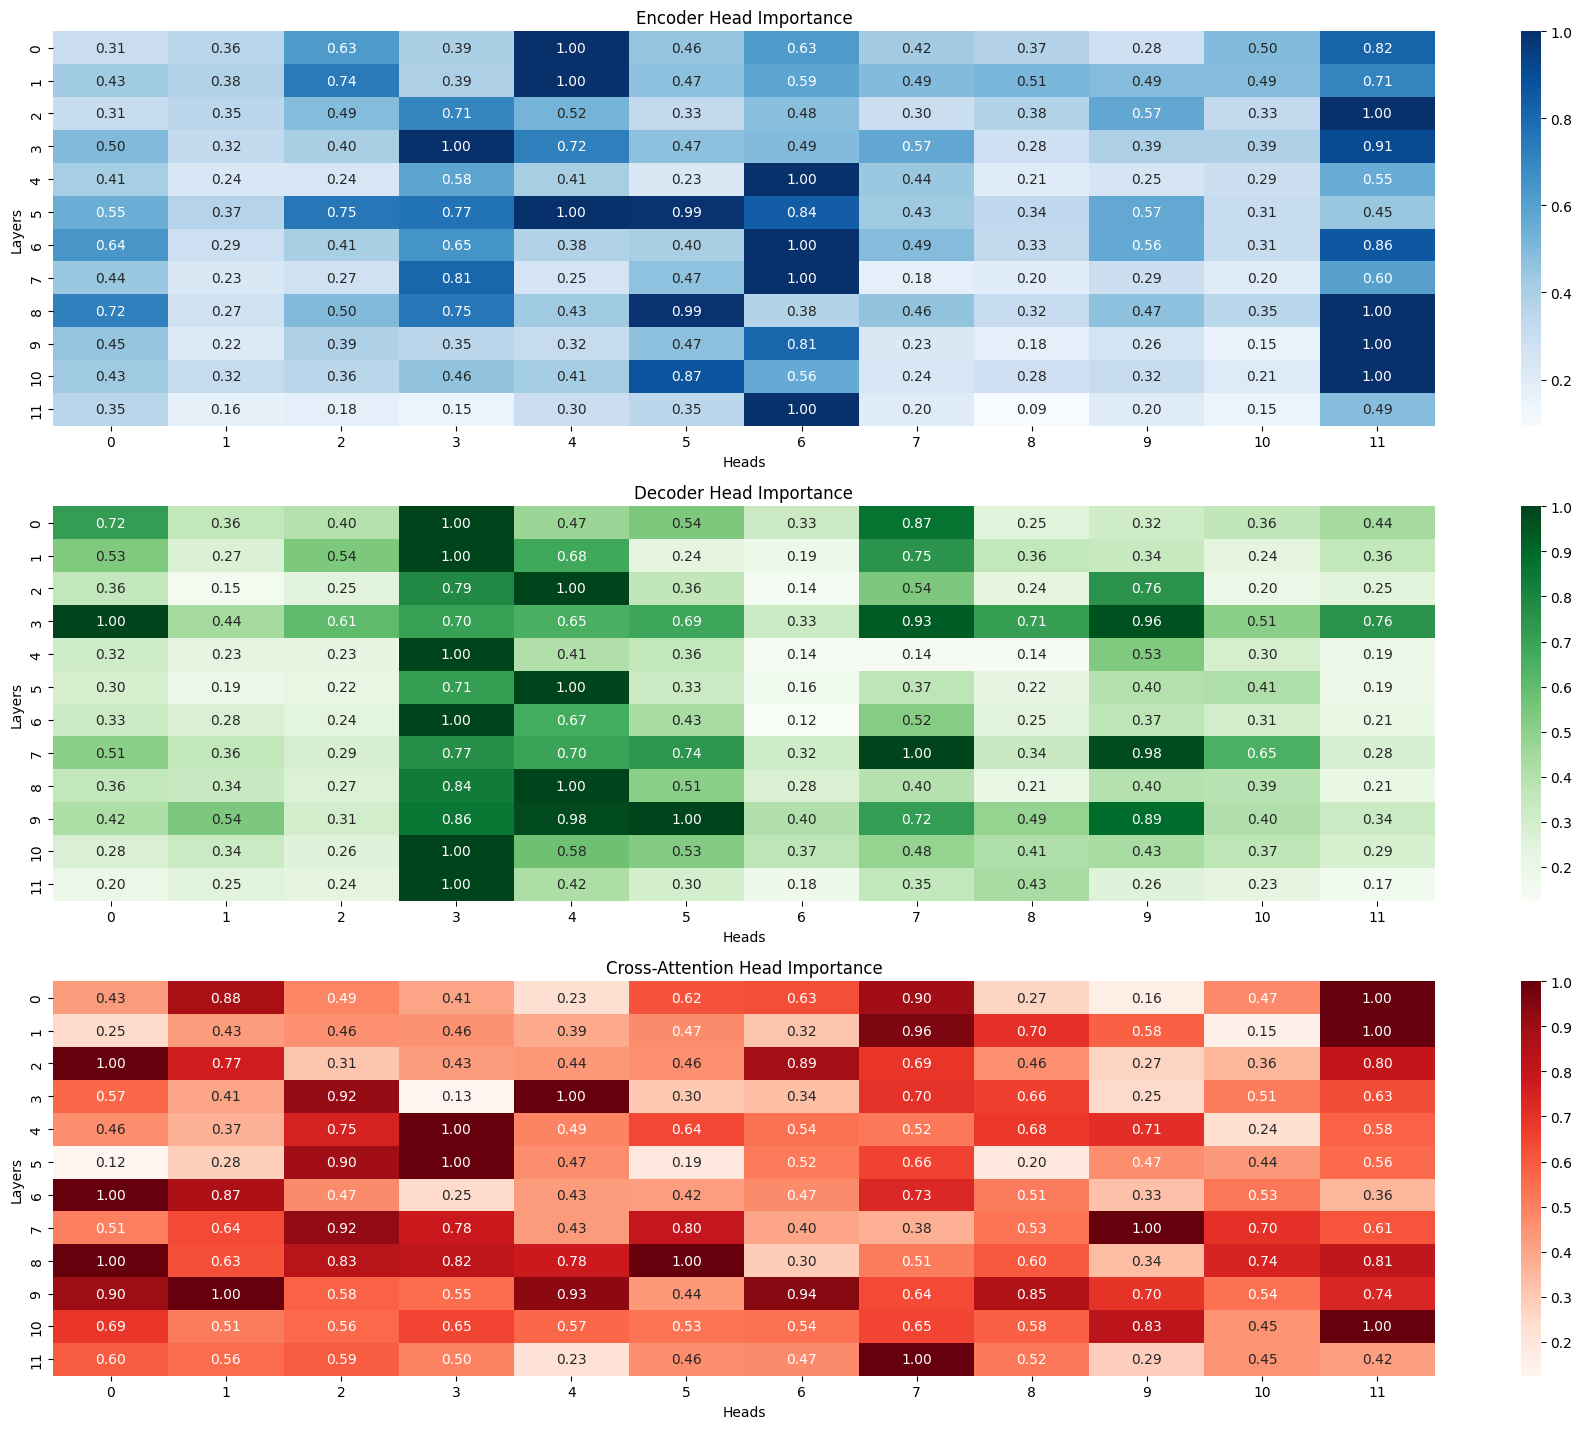

In [ ]:
# Instantiate the class
ahi = AttentionHeadImportance()

# Load dataset and get dataloader
dataloader = ahi.get_dataloader("cnn_dailymail", "3.0.0", split=split_cnn_dailymail, batch_size=batch_size_cnn_dailymail)

# Compute head importance
encoder_importance, decoder_importance, cross_attn_importance = ahi.compute_head_importance(dataloader)

# Visualize
ahi.visualize_head_importance(encoder_importance, decoder_importance, cross_attn_importance, save_path="head_imp_cnn.png")


### Evaluate Head Importance on Translation task.

validation[:5%]


README.md: 0.00B [00:00, ?B/s]

de-en/train-00000-of-00003.parquet:   0%|          | 0.00/282M [00:00<?, ?B/s]

de-en/train-00001-of-00003.parquet:   0%|          | 0.00/267M [00:00<?, ?B/s]

de-en/train-00002-of-00003.parquet:   0%|          | 0.00/277M [00:00<?, ?B/s]

de-en/validation-00000-of-00001.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

de-en/test-00000-of-00001.parquet:   0%|          | 0.00/475k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

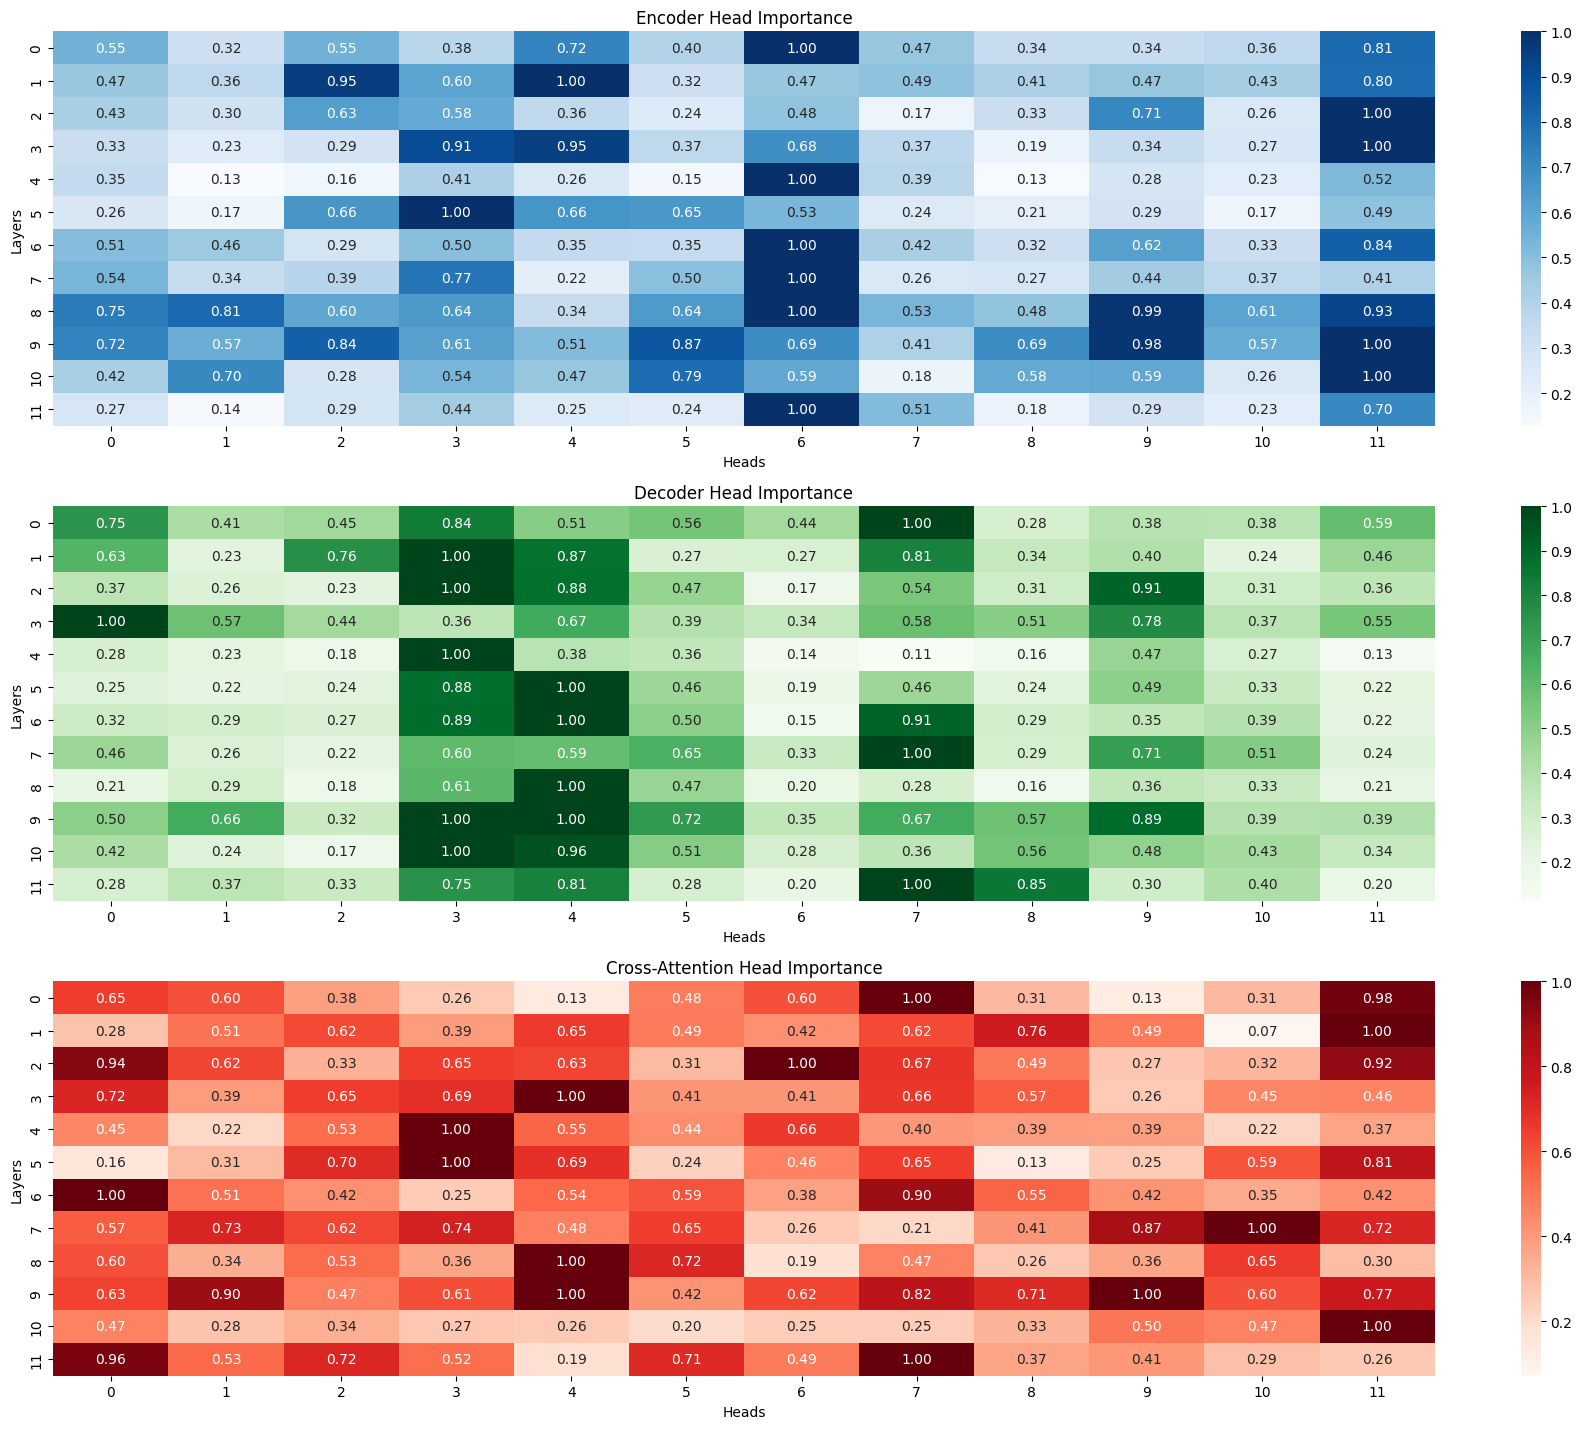

In [ ]:
# Load dataset and get dataloader
print(split_wmt16)
dataloader = ahi.get_dataloader("wmt16", "de-en", split=split_wmt16, batch_size=batch_size_wmt16)
# Compute head importance
encoder_importance, decoder_importance, cross_attn_importance = ahi.compute_head_importance(dataloader)
# Visualize
ahi.visualize_head_importance(encoder_importance, decoder_importance, cross_attn_importance, save_path="head_imp_wmt.png")

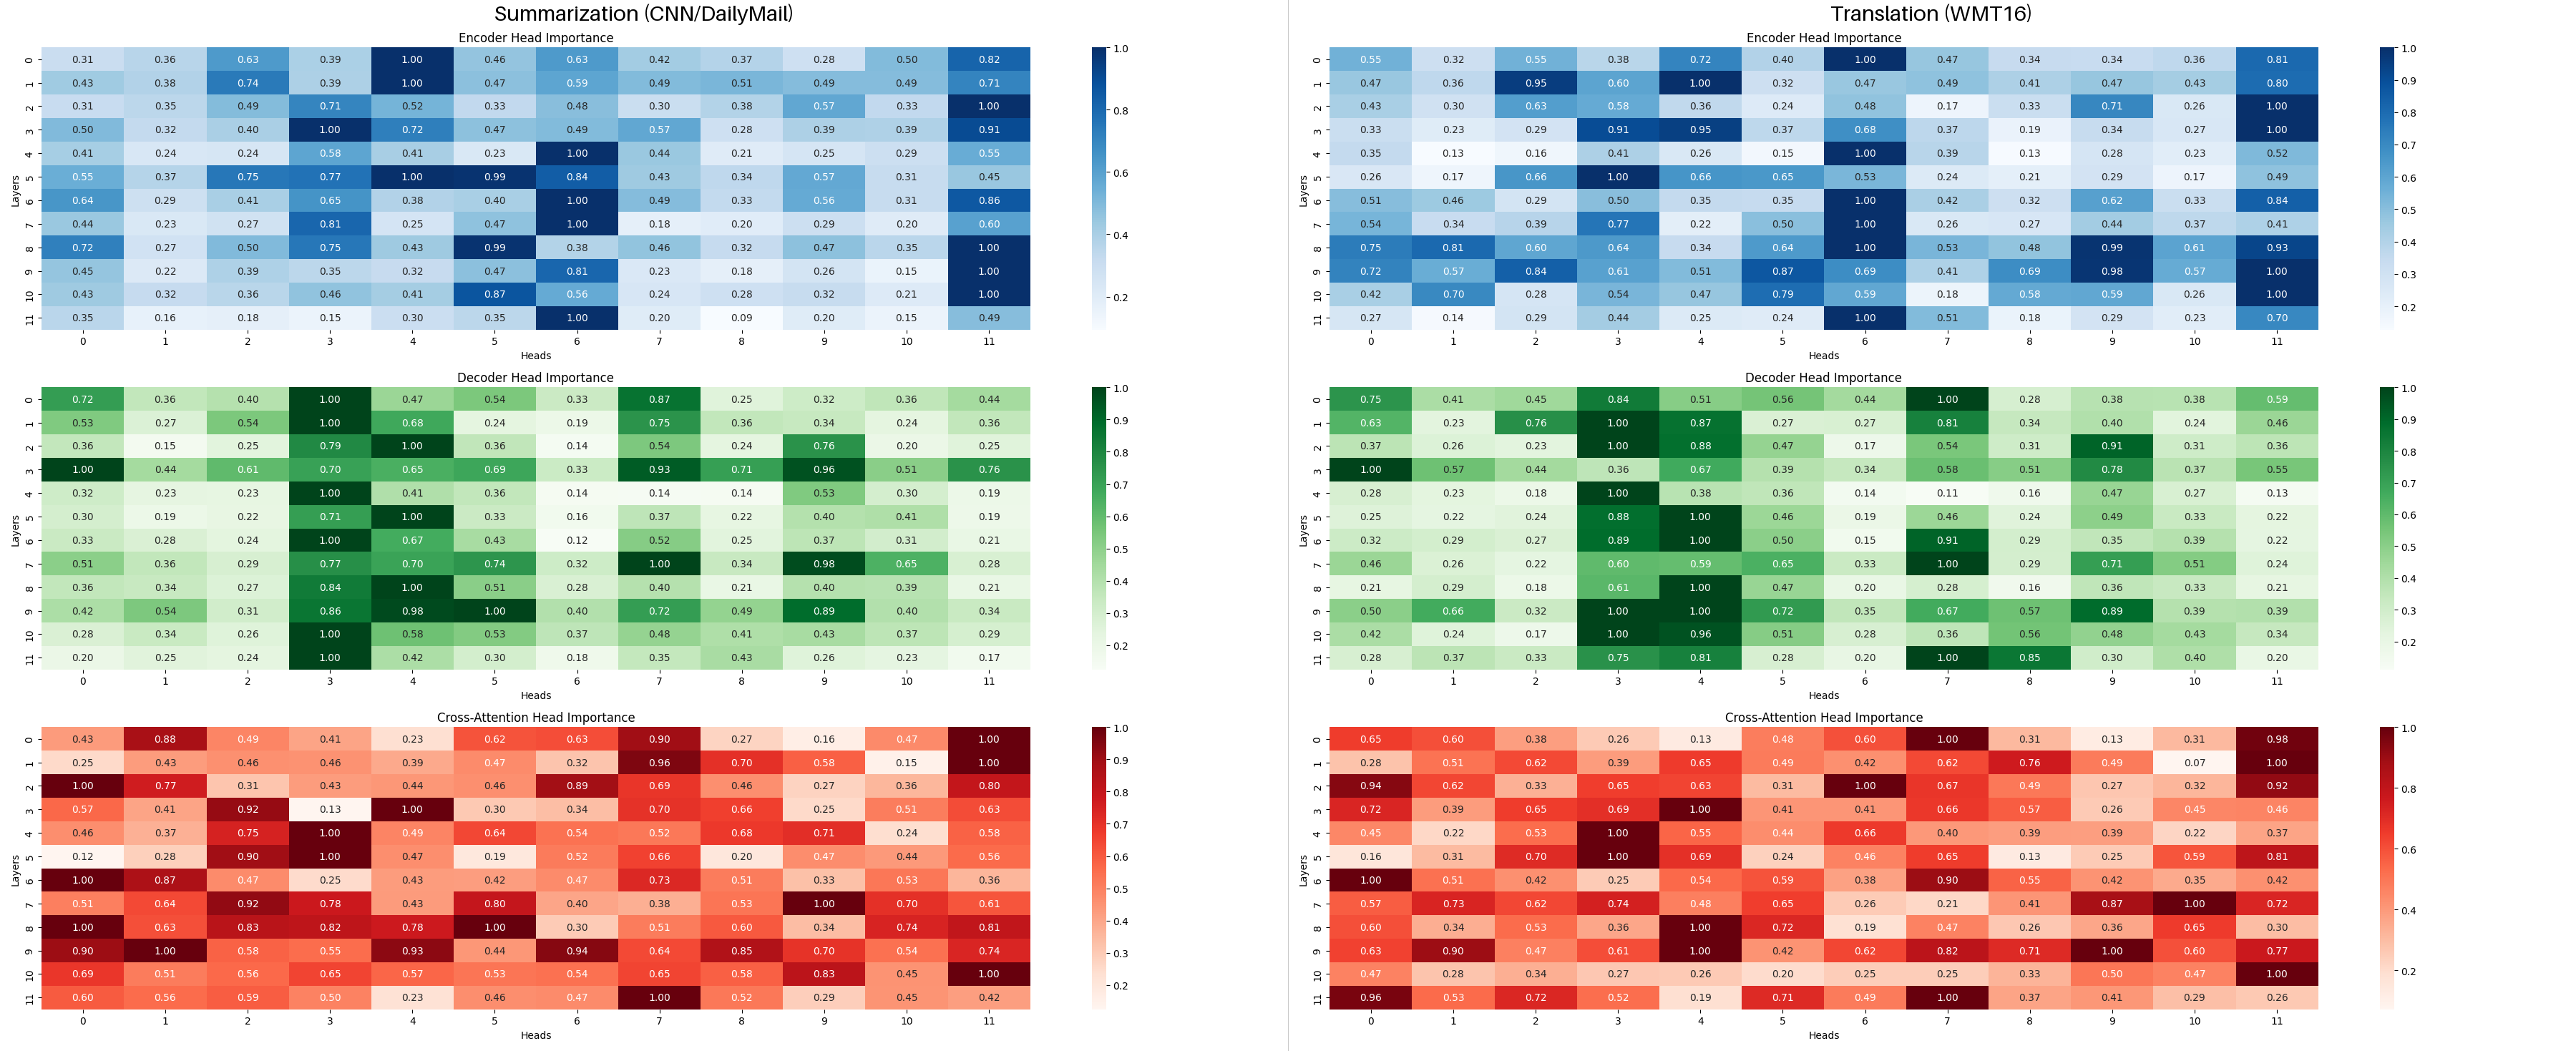

In [ ]:
# Load the saved images
img1 = Image.open("head_imp_cnn.png")
img2 = Image.open("head_imp_wmt.png")

# Get dimensions
combined_width = img1.width + img2.width
max_height = max(img1.height, img2.height)

# Create a blank image with the combined width and extra space for labels
combined_img = Image.new("RGB", (combined_width, max_height + 30), (255, 255, 255))  # White background with space for labels

# Paste the images side by side
combined_img.paste(img1, (0, 30))  # Add 30px padding at top for labels
combined_img.paste(img2, (img1.width, 30))

# Add labels
draw = ImageDraw.Draw(combined_img)
font = ImageFont.load_default(size=30)

# Add titles centered above each image
draw.text((img1.width//2, 5), "Summarization (CNN/DailyMail)", fill=(0, 0, 0), font=font, anchor="mt")
draw.text((img1.width + img2.width//2, 5), "Translation (WMT16)", fill=(0, 0, 0), font=font, anchor="mt")

# Draw a subtle separator line
draw.line([(img1.width, 0), (img1.width, max_height + 30)], fill=(200, 200, 200), width=1)

# Show the combined image
display.display(combined_img)

### Expected Observations

When analyzing the attention head importance scores across different tasks like summarization (CNN/DailyMail) and translation (WMT16), you should observe several interesting patterns:

1. **Task-Specific Heads**: Some attention heads will show dramatically different importance scores between tasks. For example, certain encoder heads might be crucial for capturing the document structure in summarization but less important for the sentence-level processing in translation. This task-specific specialization suggests that different heads learn to focus on linguistic features relevant to particular tasks.

2. **Universally Important Heads**: You'll likely identify a subset of heads with consistently high importance scores across both tasks. These "universal" heads may be responsible for fundamental language understanding capabilities like syntactic parsing or semantic relationship modeling that benefit multiple NLP tasks.


## Pruning (Masking) Heads

In [ ]:
class Pruner(AttentionHeadImportance):
    def get_mask(self, dataloader, sparsity_to_introduce, remove_from="any",
                 existing_encoder_head_mask=None, existing_decoder_head_mask=None, existing_cross_attn_head_mask=None):
        # BEGIN CODE : pruner.get_mask

        # initialize masks by cloning existing or creating new ones
        if existing_encoder_head_mask is None:
            enc_m = torch.ones(self.num_encoder_layers, self.num_heads, device=self.device)
        else:
            enc_m = existing_encoder_head_mask.clone()
        if existing_decoder_head_mask is None:
            dec_m = torch.ones(self.num_decoder_layers, self.num_heads, device=self.device)
        else:
            dec_m = existing_decoder_head_mask.clone()
        if existing_cross_attn_head_mask is None:
            x_m = torch.ones(self.num_decoder_layers, self.num_heads, device=self.device)
        else:
            x_m = existing_cross_attn_head_mask.clone()

        # create grad enabled copies for importance calculation
        enc_mg = enc_m.clone().detach().requires_grad_(True)
        dec_mg = dec_m.clone().detach().requires_grad_(True)
        x_mg = x_m.clone().detach().requires_grad_(True)

        # compute importance scores for all heads
        ei, di, xi = self.compute_head_importance(
            dataloader,
            encoder_head_mask=enc_mg,
            decoder_head_mask=dec_mg,
            cross_attn_head_mask=x_mg,
        )

        # move scores to cpu for further processing
        ei = ei.detach().cpu()
        di = di.detach().cpu()
        xi = xi.detach().cpu()

        # helper to prune heads with lowest importance
        def prune_f(m, imp, num_rm):
            act = []
            for l in range(m.shape[0]):
                for h in range(m.shape[1]):
                    if m[l, h].item() == 1:
                        act.append((imp[l, h].item(), l, h))
            act = sorted(act, key=lambda x: x[0])
            for _, l, h in act[:num_rm]:
                m[l, h] = 0
            return m

        # remove heads from any part of the model
        if remove_from == "any":
            total_hds = (self.num_encoder_layers + self.num_decoder_layers + self.num_decoder_layers) * self.num_heads
            num_rm = int(round(sparsity_to_introduce * total_hds))
            cmbd = []

            # collect active heads with importance scores
            for l in range(enc_m.shape[0]):
                for h in range(enc_m.shape[1]):
                    if enc_m[l, h].item() == 1:
                        cmbd.append((ei[l, h].item(), 'encoder', l, h))
            for l in range(dec_m.shape[0]):
                for h in range(dec_m.shape[1]):
                    if dec_m[l, h].item() == 1:
                        cmbd.append((di[l, h].item(), 'decoder', l, h))
            for l in range(x_m.shape[0]):
                for h in range(x_m.shape[1]):
                    if x_m[l, h].item() == 1:
                        cmbd.append((xi[l, h].item(), 'cross', l, h))

            # sort heads by importance
            cmbd = sorted(cmbd, key=lambda x: x[0])

            # prune heads with lowest importance
            for _, comp, l, h in cmbd[:num_rm]:
                if comp == 'encoder':
                    enc_m[l, h] = 0
                elif comp == 'decoder':
                    dec_m[l, h] = 0
                elif comp == 'cross':
                    x_m[l, h] = 0
            return enc_m, dec_m, x_m

        # remove heads only from encoder
        elif remove_from == "encoder":
            total_enc = self.num_encoder_layers * self.num_heads
            num_rm = int(round(sparsity_to_introduce * total_enc))
            enc_m = prune_f(enc_m, ei, num_rm)
            return enc_m, dec_m, x_m

        # remove heads only from decoder
        elif remove_from == "decoder":
            total_dec = self.num_decoder_layers * self.num_heads
            num_rm = int(round(sparsity_to_introduce * total_dec))
            dec_m = prune_f(dec_m, di, num_rm)
            return enc_m, dec_m, x_m

        # remove heads only from cross attention
        elif remove_from == "cross":
            total_x = self.num_decoder_layers * self.num_heads
            num_rm = int(round(sparsity_to_introduce * total_x))
            x_m = prune_f(x_m, xi, num_rm)
            return enc_m, dec_m, x_m

        else:
            raise ValueError("remove_from must be one of 'any', 'encoder', 'decoder', or 'cross'")

        # END CODE



### EVALUATION OF THE PRUNING STRATEGY

In [ ]:

def evaluate_at_different_sparsities(pruner, train_dataloader, test_dataloader, sparsities=[0, 0.2, 0.4, 0.6, 0.8, 1.0], remove_from="any"):

    encoder_mask = torch.ones((pruner.model.config.num_layers, pruner.model.config.num_heads),
                                         device=pruner.device)
    decoder_mask = torch.ones((pruner.model.config.num_layers, pruner.model.config.num_heads),
                                         device=pruner.device)
    cross_mask = torch.ones((pruner.model.config.num_layers, pruner.model.config.num_heads),
                                         device=pruner.device)

    bleu_scores = []
    cur_sparsity = 0

    for sparsity in sparsities:

        sparsity_to_introduce = sparsity - cur_sparsity
        encoder_mask, decoder_mask, cross_mask = pruner.get_mask(train_dataloader, sparsity_to_introduce, remove_from=remove_from, existing_encoder_head_mask=encoder_mask, existing_decoder_head_mask=decoder_mask, existing_cross_attn_head_mask=cross_mask)

        cur_sparsity = sparsity
        print(f"Performing evaluation when sparsity={sparsity}")
        cur_bleu_scores = []

        for batch in test_dataloader:
            input_ids = batch["input_ids"].to(pruner.device)
            labels = batch["labels"].to(pruner.device)

            output_ids = pruner.model.generate(
                input_ids,
                head_mask=encoder_mask,
                decoder_head_mask=decoder_mask,
                cross_attn_head_mask=cross_mask,
                max_length=50,
                num_beams=5,
                early_stopping=True
            )

            for i in range(len(input_ids)):
                prompt = pruner.tokenizer.decode(input_ids[i], skip_special_tokens=True)
                reference = pruner.tokenizer.decode(labels[i], skip_special_tokens=True)
                candidate = pruner.tokenizer.decode(output_ids[i], skip_special_tokens=True)
                cur_bleu_scores.append(bleu_score(candidate, reference))

        average_bleu = sum(cur_bleu_scores) / len(cur_bleu_scores)
        bleu_scores.append(average_bleu)
    return bleu_scores

In [ ]:
torch.manual_seed(42)

pruner = Pruner(model_name="t5-base")
dataloader_wmt = pruner.get_dataloader("wmt16", "de-en", split="validation[:5%]", batch_size=8) # this dataloader will be used for calculating the masks
dataloader_wmt_test = pruner.get_dataloader("wmt16", "de-en", split="test[:5%]", batch_size=8)

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

#### Pruning heads from any part of the model

Performing evaluation when sparsity=0
Performing evaluation when sparsity=0.2
Performing evaluation when sparsity=0.4
Performing evaluation when sparsity=0.6
Performing evaluation when sparsity=0.8
Performing evaluation when sparsity=1

Sparsity vs BLEU Score
Sparsity: 0.0  |  BLEU Score: 0.3843
Sparsity: 0.2  |  BLEU Score: 0.3613
Sparsity: 0.4  |  BLEU Score: 0.3187
Sparsity: 0.6  |  BLEU Score: 0.0865
Sparsity: 0.8  |  BLEU Score: 0.0450
Sparsity: 1.0  |  BLEU Score: 0.0000


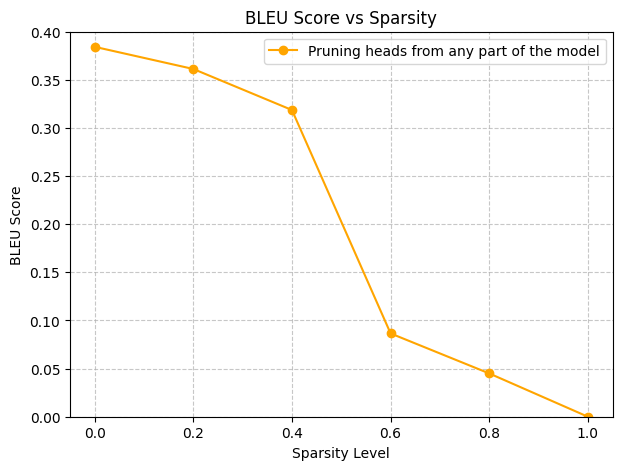

In [ ]:
torch.manual_seed(42)
sparsities = [0, 0.2, 0.4, 0.6, 0.8, 1]

bleu_scores = evaluate_at_different_sparsities(pruner, dataloader_wmt, dataloader_wmt_test, sparsities, remove_from="any")

# Print results in a formatted table
print("\nSparsity vs BLEU Score")
print("=" * 30)
for sparsity, score in zip(sparsities, bleu_scores):
    print(f"Sparsity: {sparsity:.1f}  |  BLEU Score: {score:.4f}")

# Plot BLEU Score vs Sparsity
plt.figure(figsize=(7, 5))
plt.plot(sparsities, bleu_scores, marker='o', linestyle='-', color='orange', label="Pruning heads from any part of the model")
plt.xlabel("Sparsity Level")
plt.ylabel("BLEU Score")
plt.title("BLEU Score vs Sparsity")
plt.ylim(0, 0.40)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(sparsities)
plt.savefig('prune_any.png')

score_no_sparsity = bleu_scores[0]

### Expected Observations

The bleu score will decrease as the sparsity increases but you should observe that using carefully curated masks would result in atleast 20-30% better bleu scores than random masking for 50% sparsity. As the degree of sparsity increases, the relative performance improvement should increase significantly.

#### Pruning heads from individual components

Masking heads in the encoder layers only...

Performing evaluation when sparsity=0.2
Performing evaluation when sparsity=0.4
Performing evaluation when sparsity=0.6
Performing evaluation when sparsity=0.8
Performing evaluation when sparsity=1.0

Encoder Sparsity vs BLEU Score
Sparsity: 0.2  |  BLEU Score: 0.3753
Sparsity: 0.4  |  BLEU Score: 0.3644
Sparsity: 0.6  |  BLEU Score: 0.3092
Sparsity: 0.8  |  BLEU Score: 0.1116
Sparsity: 1.0  |  BLEU Score: 0.0371

Masking heads in the decoder layers only...

Performing evaluation when sparsity=0.2
Performing evaluation when sparsity=0.4
Performing evaluation when sparsity=0.6
Performing evaluation when sparsity=0.8
Performing evaluation when sparsity=1.0

Decoder Sparsity vs BLEU Score
Sparsity: 0.2  |  BLEU Score: 0.3835
Sparsity: 0.4  |  BLEU Score: 0.3759
Sparsity: 0.6  |  BLEU Score: 0.3729
Sparsity: 0.8  |  BLEU Score: 0.2472
Sparsity: 1.0  |  BLEU Score: 0.0445

Masking cross-attention heads only...

Performing evaluation when sparsity

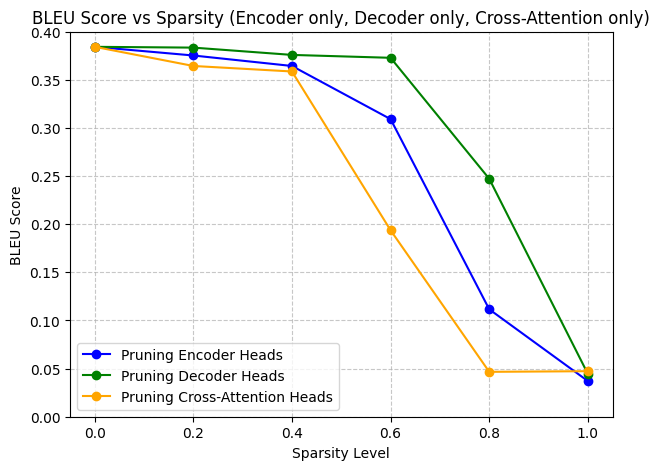

In [ ]:
torch.manual_seed(42)
sparsities = [0.2, 0.4, 0.6, 0.8,1.0]

print("Masking heads in the encoder layers only...\n")
encoder_bleu_scores = evaluate_at_different_sparsities(pruner, dataloader_wmt, dataloader_wmt_test, sparsities, remove_from="encoder")

print("\nEncoder Sparsity vs BLEU Score")
print("=" * 30)

for sparsity, score in zip(sparsities, encoder_bleu_scores):
    print(f"Sparsity: {sparsity:.1f}  |  BLEU Score: {score:.4f}")

torch.manual_seed(42)

print("\nMasking heads in the decoder layers only...\n")
decoder_bleu_scores = evaluate_at_different_sparsities(pruner, dataloader_wmt, dataloader_wmt_test, sparsities, remove_from="decoder")

print("\nDecoder Sparsity vs BLEU Score")
print("=" * 30)

for sparsity, score in zip(sparsities, decoder_bleu_scores):
    print(f"Sparsity: {sparsity:.1f}  |  BLEU Score: {score:.4f}")

torch.manual_seed(42)

print("\nMasking cross-attention heads only...\n")
cross_bleu_scores = evaluate_at_different_sparsities(pruner, dataloader_wmt, dataloader_wmt_test, sparsities, remove_from="cross")

print("\nCross-Attention Sparsity vs BLEU Score")
print("=" * 30)
for sparsity, score in zip(sparsities, cross_bleu_scores):
    print(f"Sparsity: {sparsity:.1f}  |  BLEU Score: {score:.4f}")

# Prepend and append the scores for no sparsity and total sparsity
encoder_bleu_scores.insert(0, score_no_sparsity)

decoder_bleu_scores.insert(0, score_no_sparsity)

cross_bleu_scores.insert(0, score_no_sparsity)

sparsities.insert(0, 0)

plt.figure(figsize=(7, 5))
plt.plot(sparsities, encoder_bleu_scores,
         marker='o', linestyle='-', color='blue', label="Pruning Encoder Heads")
plt.plot(sparsities, decoder_bleu_scores,
         marker='o', linestyle='-', color='green', label="Pruning Decoder Heads")
plt.plot(sparsities, cross_bleu_scores,
         marker='o', linestyle='-', color='orange', label="Pruning Cross-Attention Heads")
plt.xlabel("Sparsity Level")
plt.ylabel("BLEU Score")
plt.title("BLEU Score vs Sparsity (Encoder only, Decoder only, Cross-Attention only)")
plt.ylim(0, 0.40)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(sparsities)
plt.savefig('prune_encoder_decoder_cross.png')

### Expected Observations

You should see that the impact of pruning to different sparsity levels in different components (encoder, decoder, cross-attention) is not the same. Pruning a certain percentage from some component may result in a much larger performance degradation compared to pruning the same percentage from another component. Moreover, you might observe that when you prune carefully, the performance degradation from component A might be worse than that for component B. But when you prune randomly, the trend might switch. This may mean that certain components contain a higher concentration of critical heads whilst other components have their importance more evenly distributed across heads, making them more resilient to targeted pruning but potentially more vulnerable to random pruning.

# Congratulations!

You've reached the end.